# Neural Networks

In [1]:
import os

os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

'2'

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, regularizers
from sklearn import metrics
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, GaussianDropout, BatchNormalization
from scipy import stats

In [3]:
import tensorflow as tf
from tensorflow import keras
tfk = tf.keras
tfkl = tf.keras.layers
tf.config.set_visible_devices([], 'GPU') #disables GPU

## Data

In [4]:

# Load the CSV file
data = pd.read_csv("BC-Data-Set.csv")

In [5]:
# Convert the date column to a datetime object
data['date'] = pd.to_datetime(data['date'])

# Remove any missing values
data = data.dropna()

# Set the date column as the index of the DataFrame
data = data.set_index('date')

In [6]:
seed = 42

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data[['BC','N_CPC', 'PM-2.5', 'PM-1.0', 'O3', 'CO', 'NOX', 'TEMP', 'HUM']], data.BC, test_size=0.15, random_state=seed, shuffle=True)
x_train = x_train.drop(columns=['BC'])
x_test = x_test.drop(columns=['BC'])

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = scaler_y.transform(np.array(y_test).reshape(-1, 1))

In [9]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3589, 8), (634, 8), (3589, 1), (634, 1))

In [10]:
data

,BC,N_CPC,PM-10,PM-2.5,PM-1.0,NO2,O3,SO2,CO,NO,NOX,TEMP,HUM
date,,,,,,,,,,,,,
2019-01-01 00:00:00,3.445,17.773,13.033,11.767,11.050,18.0,41.0,1.0,0.2,4.0,23.0,12.140,53.780
2019-01-01 01:00:00,5.162,24.620,17.050,15.533,14.783,62.0,1.0,1.0,0.2,22.0,96.0,11.683,55.100
2019-01-01 02:00:00,2.951,17.700,11.417,10.367,9.850,68.0,1.0,1.0,0.2,42.0,132.0,11.683,53.433
2019-01-01 03:00:00,1.917,12.212,7.750,7.100,6.683,75.0,1.0,1.0,0.2,66.0,176.0,11.367,54.533
2019-01-01 04:00:00,2.462,11.178,8.317,7.650,7.167,63.0,1.0,1.0,0.2,27.0,103.0,10.867,57.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-10 19:00:00,0.728,9.275,7.300,5.267,3.267,30.0,57.0,1.0,0.2,2.0,33.0,22.033,93.367
2019-12-10 20:00:00,0.787,9.420,7.500,5.467,3.417,37.0,46.0,1.0,0.2,1.0,38.0,22.100,93.317
2019-12-10 21:00:00,1.056,9.296,7.233,5.283,3.200,16.0,67.0,1.0,0.2,1.0,17.0,22.200,93.333


In [11]:
def plot_residuals(model, X_, y_):
    X=pd.DataFrame(X_).copy()
    y=pd.DataFrame(y_).copy()
    X['sort'] = y
    X = X.sort_values(by=['sort'])
    y = np.expand_dims(X['sort'], 1)
    X.drop(['sort'], axis=1, inplace=True)

    y_pred = model.predict(X)
    SSE = np.square(scaler_y.inverse_transform(y_pred) - scaler_y.inverse_transform(y))
    MSE = np.mean(SSE)
    score = r2_score(scaler_y.inverse_transform(y),  scaler_y.inverse_transform(y_pred))

    print('\R2:', score)
    print('\MSE:', MSE)
    # mpl.rcParams.update(mpl.rcParamsDefault)
    # sns.set(font_scale=1.1, style=None, palette='Set1')
    plt.figure(figsize=(20,5))
    plt.scatter(np.arange(len(y)), y, label='True')
    plt.scatter(np.arange(len(y_pred)), y_pred, label='Prediction')
    
    for i in range(len(y_)):
        if(y[i]>=y_pred[i]):
            plt.vlines(i,y_pred[i],y[i],alpha=.5)
        else:
            plt.vlines(i,y[i],y_pred[i],alpha=.5)
            
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

## Neural Network (non-LSTM)

In [12]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, shuffle=True, random_state=seed)

In [13]:
model = tf.keras.Sequential()
model.add(Dense(96, activation='elu', input_shape=[x_train.shape[-1]]))
model.add(Dense(96, activation='elu'))
model.add(Dense(96, activation='elu'))
model.add(tf.keras.layers.Dense(1))

model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
            loss=tf.losses.mean_squared_error,
        )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                864       
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                                 
 dense_2 (Dense)             (None, 96)                9312      
                                                                 
 dense_3 (Dense)             (None, 1)                 97        
                                                                 
Total params: 19,585
Trainable params: 19,585
Non-trainable params: 0
_________________________________________________________________


In [14]:

batch_size = 32 
epochs = 2000
logs = model.fit(
    x_train, y_train,
    batch_size=batch_size, epochs=epochs,
    validation_data=(x_valid, y_valid),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30,  restore_best_weights=True)
                            ],
    verbose=2
)

Epoch 1/2000


96/96 - 0s - loss: 0.4306 - val_loss: 0.3785 - 305ms/epoch - 3ms/step
Epoch 2/2000
96/96 - 0s - loss: 0.3309 - val_loss: 0.4051 - 82ms/epoch - 852us/step
Epoch 3/2000
96/96 - 0s - loss: 0.3129 - val_loss: 0.3408 - 84ms/epoch - 876us/step
Epoch 4/2000
96/96 - 0s - loss: 0.2979 - val_loss: 0.3342 - 82ms/epoch - 853us/step
Epoch 5/2000
96/96 - 0s - loss: 0.2959 - val_loss: 0.3305 - 75ms/epoch - 779us/step
Epoch 6/2000
96/96 - 0s - loss: 0.2831 - val_loss: 0.2991 - 78ms/epoch - 815us/step
Epoch 7/2000
96/96 - 0s - loss: 0.2830 - val_loss: 0.3103 - 74ms/epoch - 766us/step
Epoch 8/2000
96/96 - 0s - loss: 0.2769 - val_loss: 0.3107 - 73ms/epoch - 760us/step
Epoch 9/2000
96/96 - 0s - loss: 0.2755 - val_loss: 0.2904 - 75ms/epoch - 777us/step
Epoch 10/2000
96/96 - 0s - loss: 0.2668 - val_loss: 0.3125 - 72ms/epoch - 748us/step
Epoch 11/2000
96/96 - 0s - loss: 0.2782 - val_loss: 0.2938 - 72ms/epoch - 752us/step
Epoch 12/2000
96/96 - 0s - loss: 0.2643 - val_loss: 0.2791 - 72ms/epoch - 753us/step
Epo

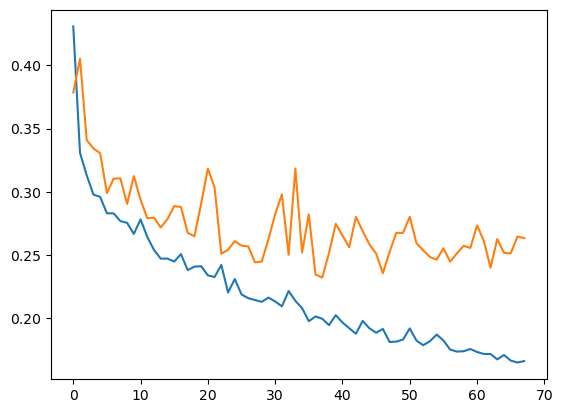

In [15]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])

17/17 [==============================] - 0s 486us/step
\R2: 0.8100604874155051
\MSE: 0.29731649574857344


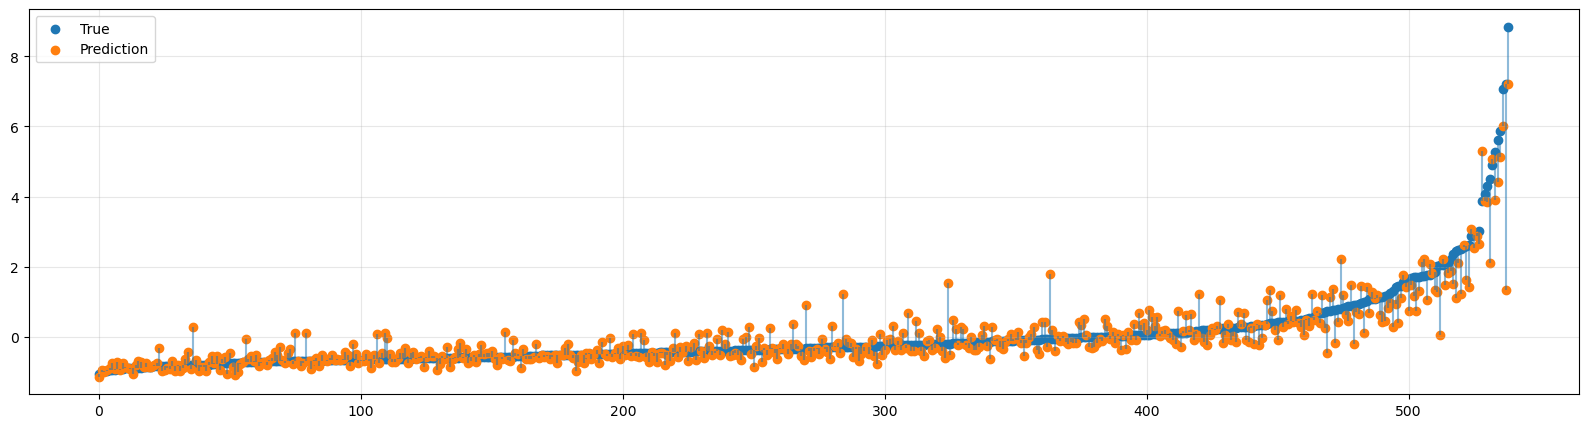

In [21]:
plot_residuals(model, x_valid, y_valid)

20/20 [==============================] - 0s 997us/step
\R2: 0.7621165859784355
\MSE: 0.27171760154419367


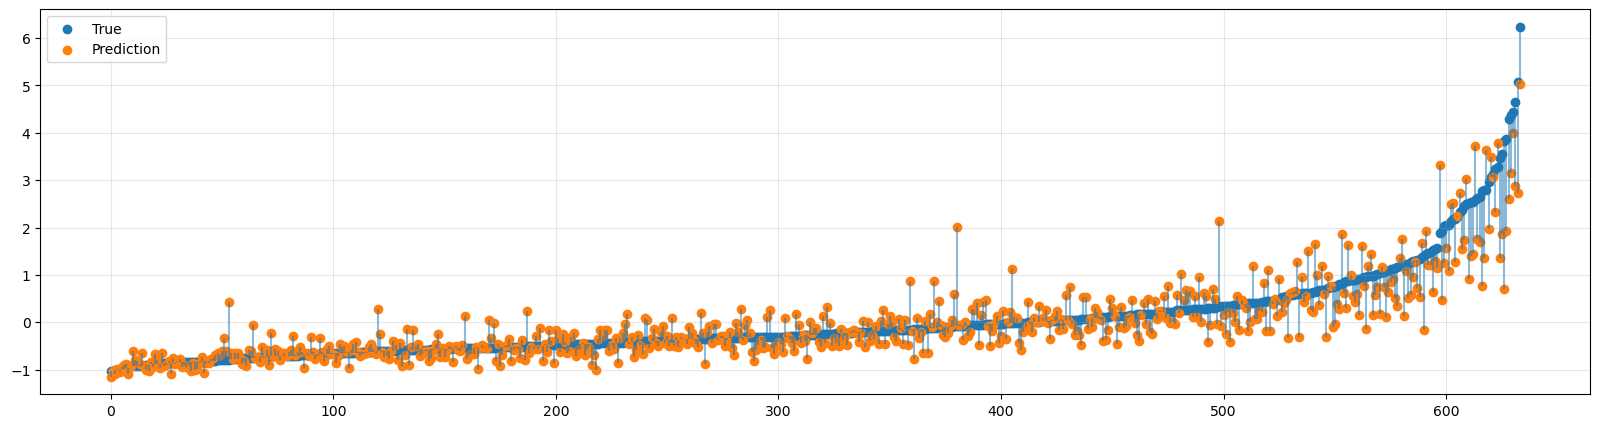

In [16]:
plot_residuals(model, x_test, y_test)

In [17]:
model1 = tf.keras.Sequential()
#model1.add(GaussianNoise(0.1))
model1.add(Dense(64, activation='relu', input_shape=[x_train.shape[-1]], kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.0)))
#model1.add(BatchNormalization())
#model1.add(Dropout(0.1))
model1.add(GaussianNoise(0.1))
model1.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0, l2=0.0)))
#model1.add(BatchNormalization())
#model1.add(Dropout(0.1))
model1.add(GaussianNoise(0.05))
model1.add(Dense(96, activation='relu', input_shape=[x_train.shape[-1]], kernel_regularizer=regularizers.l1_l2(l1=0.0, l2=0.0)))
#model1.add(BatchNormalization())
model1.add(Dropout(0.1))
model1.add(tf.keras.layers.Dense(1))

model1.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
            loss=tf.losses.mean_squared_error,
        )
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                576       
                                                                 
 gaussian_noise (GaussianNoi  (None, 64)               0         
 se)                                                             
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 gaussian_noise_1 (GaussianN  (None, 128)              0         
 oise)                                                           
                                                                 
 dense_6 (Dense)             (None, 96)                12384     
                                                                 
 dropout (Dropout)           (None, 96)               

In [18]:
batch_size = 32 
epochs = 2000
logs = model1.fit(
    x_train, y_train,
    batch_size=batch_size, epochs=epochs,
    validation_data=(x_valid, y_valid),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=100,  restore_best_weights=True),
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=50, min_lr=0.0001)
                ],
    verbose=2
)

Epoch 1/2000
96/96 - 0s - loss: 0.4582 - val_loss: 0.3662 - lr: 0.0010 - 277ms/epoch - 3ms/step
Epoch 2/2000
96/96 - 0s - loss: 0.3186 - val_loss: 0.3236 - lr: 0.0010 - 79ms/epoch - 825us/step
Epoch 3/2000
96/96 - 0s - loss: 0.2974 - val_loss: 0.3089 - lr: 0.0010 - 77ms/epoch - 802us/step
Epoch 4/2000
96/96 - 0s - loss: 0.2884 - val_loss: 0.2902 - lr: 0.0010 - 76ms/epoch - 796us/step
Epoch 5/2000
96/96 - 0s - loss: 0.2730 - val_loss: 0.2997 - lr: 0.0010 - 76ms/epoch - 788us/step
Epoch 6/2000
96/96 - 0s - loss: 0.2707 - val_loss: 0.2928 - lr: 0.0010 - 80ms/epoch - 833us/step
Epoch 7/2000
96/96 - 0s - loss: 0.2503 - val_loss: 0.2832 - lr: 0.0010 - 77ms/epoch - 807us/step
Epoch 8/2000
96/96 - 0s - loss: 0.2381 - val_loss: 0.3040 - lr: 0.0010 - 76ms/epoch - 787us/step
Epoch 9/2000
96/96 - 0s - loss: 0.2551 - val_loss: 0.2939 - lr: 0.0010 - 74ms/epoch - 771us/step
Epoch 10/2000
96/96 - 0s - loss: 0.2486 - val_loss: 0.2813 - lr: 0.0010 - 74ms/epoch - 770us/step
Epoch 11/2000
96/96 - 0s - los

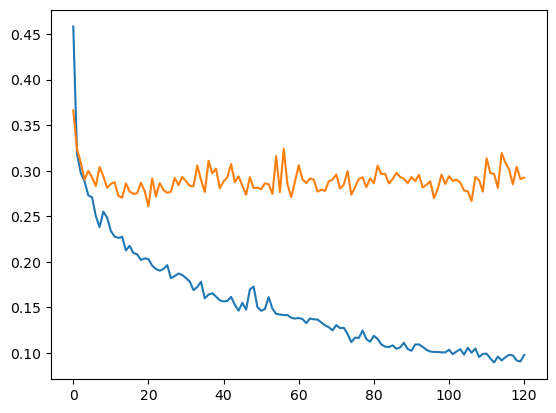

In [19]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])

20/20 [==============================] - 0s 407us/step
\R2: 0.7320889951298174
\MSE: 0.3060160203687917


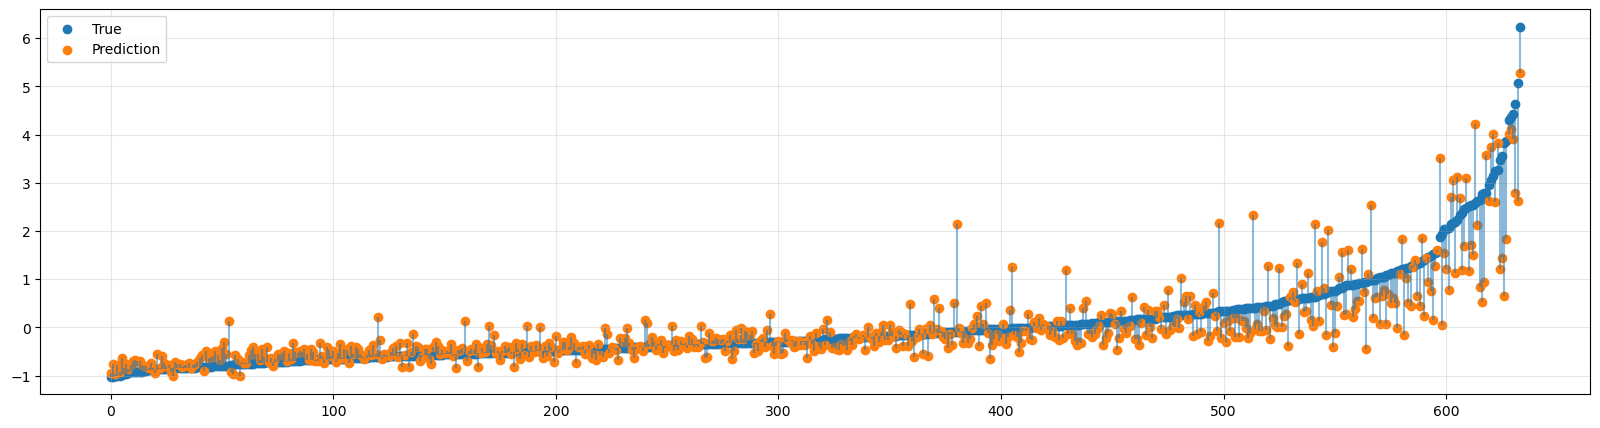

In [20]:
plot_residuals(model1, x_test, y_test)

17/17 [==============================] - 0s 428us/step
\R2: 0.7867787654932668
\MSE: 0.3337598870299602


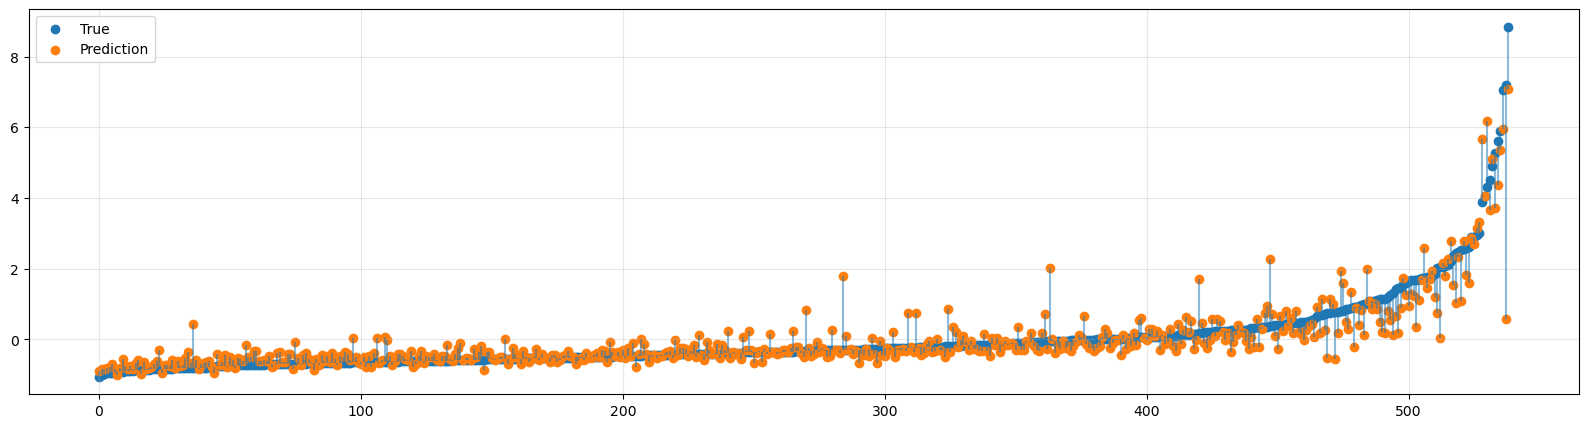

In [22]:
plot_residuals(model1, x_valid, y_valid)